[ ] Submitted weak source erange [6:15]m binsize = 0.08, id: 71988



# Import the Dataset

In this notebook a 3D analysis of the Crab is demonstated. In addition to the usuall model parameters so called 'nuisance parameters' are fitted which account for any systematical uncertainties. These sysetmatical uncertainties are assumed to be due a missmodelling of the hardronic background. 

The nuisance parameters are correlated so they can only eliminate the systemtic uncertainties but not the uncorrelated statistical uncertainicies.  

The notebook is structed as follows:

- Setting up the correlation of the nuisacane parameters
- Fitting the model and the nuisance parameters to the data
- Compare the results to the standard 3D fit

In [1]:
#get_ipython().system('jupyter nbconvert --to script 5a-Tutorial_Nui_Par_Fitting_Crab.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit

## Standard Analysis
Setting up the model

Crab: icrs
GAUSSIAN: SkyModel

  Name                      : Crab_Gaussian
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   3.70e-11   +/- 2.8e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    alpha                   :      2.513   +/-    0.02             
    beta                    :      0.103   +/-    0.01             
    lon_0                   :     83.631   +/-    0.00 deg         
    lat_0                   :     22.018   +/-    0.00 deg         
    sigma                   :      0.500   +/-    0.00 deg         
    e            (frozen)   :      0.000                   
    phi          (frozen)   :      0.000       deg         


GAUSSIAN: icrs
BG counts: 35298.164
Source counts: 15339.786505127251
The Crab is 43.45774606850985 % of the BG!
Setting new sources amplitude to 

Text(0.5, 1.0, 'Point source 50% of BG')

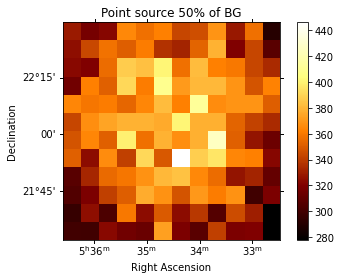

In [4]:
source = 'Crab_gaussian'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
source_percentage = 50 # percent
gaussian_size = 0.5 *u.deg
if source == "Crab":

    # here the dataset with the fine binning is saved
    #dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
    # This is for now the binning of 0.08 deg
    dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')

    models = Models.read(f"{source}/standard_model.yml")
    
    with open(f"{source}/nui_bgmodel.yml", "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
    bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
    models.append(bkg_model)
    dataset_standard.models = models
    cutout = 1*u.deg
    geom = dataset_standard.geoms['geom']
    bg_counts = dataset_standard.npred_background().cutout(geom.center_skydir, cutout).data.sum()
    crab_counts = dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum()

    print("BG counts:",bg_counts )
    print("Source counts:",crab_counts )
    source_percentage_crab = crab_counts/bg_counts
    print(f"The Crab is {source_percentage_crab*100} % of the BG!")
    while (dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum() /bg_counts *100 >source_percentage):
        dataset_standard.models.parameters['amplitude'].value *=0.99
    models_input = dataset_standard.models.copy()  
    print("Setting new sources amplitude to ... ")
    print(dataset_standard.models.parameters['amplitude'].value)
    print("This is in BG percentage: ")
    print(dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum() /bg_counts *100)
    rng = np.random.RandomState()
    dataset_standard.counts.data = rng.poisson(dataset_standard.npred().data)
    
if source == "Crab_gaussian":

    # here the dataset with the fine binning is saved
    dataset_standard = MapDataset.read(f'{path}/Crab/stacked.fits')
    dataset_standard = dataset_standard.downsample(4)
    # This is for now the binning of 0.08 deg
    #dataset_standard = MapDataset.read(f'{path}/Crab/stacked.fits')

    models = Models.read(f"Crab/standard_model.yml")
    print("Crab:",models[0].spatial_model.frame)
    gaussian_model = GaussianSpatialModel(lon_0 = models[0].parameters['lon_0'],
                                          lat_0 = models[0].parameters['lat_0'],
                                         sigma = gaussian_size,
                                          frame = models[0].spatial_model.frame
                                         )
    spectral_model = models[0].spectral_model.copy() 
    source_model = SkyModel(spatial_model=gaussian_model,
                            spectral_model=spectral_model, name="Crab_Gaussian")

    print("GAUSSIAN:", source_model)
    print("GAUSSIAN:", gaussian_model.frame)
    
    
    with open(f"Crab/nui_bgmodel.yml", "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
    bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
    models.append(bkg_model)
    dataset_standard.models = source_model
    cutout = 1*u.deg
    geom = dataset_standard.geoms['geom']
    bg_counts = dataset_standard.npred_background().cutout(geom.center_skydir, cutout).data.sum()
    crab_counts = dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum()

    print("BG counts:",bg_counts )
    print("Source counts:",crab_counts )
    source_percentage_crab = crab_counts/bg_counts
    print(f"The Crab is {source_percentage_crab*100} % of the BG!")
    while (dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum() /bg_counts *100 >source_percentage):
        dataset_standard.models.parameters['amplitude'].value *=0.99
    models_input = dataset_standard.models.copy()  
    print("Setting new sources amplitude to ... ")
    print(dataset_standard.models.parameters['amplitude'].value)
    print("This is in BG percentage: ")
    print(dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum() /bg_counts *100)
    rng = np.random.RandomState()
    dataset_standard.counts.data = rng.poisson(dataset_standard.npred().data)
    
    
dataset_standard.cutout(geom.center_skydir, cutout).counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)
plt.title(f"Point source {source_percentage}% of BG")



In [3]:
fit_standarad = Fit(store_trace=False)
result_standarad = fit_standarad.run([dataset_standard])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (68.45411389, 46.25020855)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (68.45411389, 46.25020855)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (77.65578013, 6.95095507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (77.65578013, 6.95095507)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (81.84076349, -89.79202534)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (81.84076349, -89.79202534)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.31724376, -2.475177)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCo

KeyboardInterrupt: 

In [ ]:
parameter_standard = dataset_standard.models[0].parameters['amplitude']
par_error = 1.12e-13

parameter_standard.scan_values = np.linspace(
    #parameter_standard.value-2*par_error,
    0,
    parameter_standard.value#+2*par_error,
    ,5 )
f_standard = fit_standarad.stat_profile(
                    datasets =  [dataset_standard],
                    parameter=  parameter_standard, 
                    reoptimize = True ) 

In [ ]:
fig = plt.figure()
ax = plt.gca()
stat_standard =  f_standard['stat_scan'] -  min(f_standard['stat_scan'])
#stat_N =  f_N['stat_scan'] -  min(f_N['stat_scan'])


plt.plot(f_standard['amplitude_scan'],stat_standard, 
         label = "Standard Analysis \n{:.3} $\pm$ {:.2}".format(parameter_standard.value ,
                                                        parameter_standard.error), 
         color = 'orange' )

The first two energybins of the dataset are not fitted well ...

In [ ]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 9)))
    .smooth(0.1 * u.deg)
)
vmax = np.nanmax(np.abs(res_standard.data))
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

In [ ]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

## Nuisance Parameters

Firstly, the expected ampitude of the systematics for the different energybins are read. They can either be in terms of std or in percentage of the bg. Since in the end the nuisance parameters are in percentage of bg, we want the amplitude in the same unit..

Here, two things are used to save computation time:
- The nuisance parameters are computed only within the first two energybins of the analysis (index 4 and 5) exemplary to save computation time. The indices are defined as `i_start` and `i_end`. This approximation is fine since the systematic uncertainites are known to be the largest at the smaller energies. 
- The nuisance parameter have a larger binsize than the counts cube. The downsampling factor `downsampling_factor` denotes that. This way, one nuisance parameter acts on multiple neighbor bins and the systematic uncertainty is averaged over them. The geometry of this downsampled nuisance parameter cube is saved in `dataset.geoms['geom_down']`.




### Systematic Amplitude

In [ ]:
bg = (
    dataset_standard.background
    .data.sum(axis=2)
    .sum(axis=1)
)

#sysamplitude_std = np.loadtxt(f'{source}/sysamplitude.txt')
# Convert to %:
#sysamplitude_std /= np.sqrt(bg)


sysamplitude_percentage = np.loadtxt((f'{path}/{source}/sysamplitude_percentage.txt'))
# Convert to %:
sysamplitude_percentage /= 100
print("sysamplitude_percentage:",sysamplitude_percentage)
plt.plot(dataset_standard.geoms["geom"].axes[0].center.value,
         sysamplitude_percentage,
        label ="Expected Strength of Systematic")

bg_counts_energy =dataset_standard.npred_background().cutout(geom.center_skydir, cutout).data.sum(axis = 2).sum(axis=1)
source_counts_energy =dataset_standard.npred_signal().cutout(geom.center_skydir, cutout).data.sum(axis = 2).sum(axis=1)
percent_source = source_counts_energy/bg_counts_energy




plt.plot(dataset_standard.geoms["geom"].axes[0].center.value,
        percent_source, label = "Strength of the Source")
plt.xscale('log')
plt.ylabel("Expected Systematic")
plt.xlabel("Energy [TeV]")
plt.legend()
#choose between the following:
sigma = sysamplitude_percentage 
#sigma = sysamplitude_std 


emask = sigma >0
print("Estimated systematic uncertainty: ")
print()
print("Ebin               [Counts]    [% BG]")

for i, e in enumerate(dataset_standard.geoms['geom'].axes[0].center.value):
    e_start, e_end = (
        dataset_standard.geoms["geom"].axes[0].edges[ i],
        dataset_standard.geoms["geom"].axes[0].edges[i + 1],
    )
    sys_percent = sigma[i]
    sys_counts =  sigma[i] * bg[i]
    

    print(
        f"{np.round(e_start.value,1):<4} : {np.round(e_end.value,1):<6} TeV:  {np.round(sys_counts,0):<10}  {np.round(sys_percent,3):<5}  "
        )
    
    


### Downsampling Factor

In [ ]:
angular_size_file = f'{source}/angular_size.txt'
angular_size = np.loadtxt(angular_size_file)
ndim_spatial = dataset_standard.geoms['geom'].data_shape[1]
print("Current Binning:", ndim_spatial)
possible_downsampling_factors = []
possible_binsizes = []
for i in range(1, ndim_spatial):
    if (ndim_spatial%i == 0):
        possible_downsampling_factors.append(i)
        possible_binsizes.append(binsize[0].value * i)


print(f"Possible downsampling factors: {possible_downsampling_factors}")
print(f"Resulting Binsize: {possible_binsizes}")

downsampling_factor_index = -1
while (possible_binsizes[downsampling_factor_index] > angular_size):
    downsampling_factor_index -=1
downsampling_factor =    possible_downsampling_factors[downsampling_factor_index]

# ##############################
downsampling_factor = 50
# ##############################


print()
print(f"Chosen Downsampling Factor: \n {downsampling_factor}.")
print(f"This will result in a Binsize of the Nuisance Parameters of \n {possible_binsizes[downsampling_factor_index]} deg.")
print(f"Which is smaller than the observed angular size of the systematics of \n {angular_size} deg.")

geom_down = dataset_standard.downsample(downsampling_factor).geoms['geom']


## Import Nuisance Parameter Dataset

In [ ]:
path_sys = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/'

ebins = range(6,20)
i_start, i_end = 6,8
pathsource = f"{source}/"
dataset_N = MapDatasetNuisance.read(f"{path_sys}/{pathsource}nui_dataset_weak.fits")
with open(f'{pathsource}nui_par_weak.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N.N_parameters = Parameters.from_dict(nui_par )
with open(f'{pathsource}nui_model_weak.yml', "r") as ymlfile:
    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(f'{pathsource}nui_bgmodel_weak.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_N.name)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
models = Models.from_dict(best_fit_model )
models.append(bkg_model)
dataset_N.models =models
dataset_N.geoms['geom']
print(dataset_N)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset_N.inv_corr_matrix)  # interpolation='nearest')
fig.colorbar(cax);

# Initiate the MapDatasetNuisance

The MapDatasetNuisance class takes in addition to the MapDataset class:
- `inv_corr_matrix`: The inverse of the correlation matrix 
- ` N_parameters`: The nuisance parameters
- `nuisance_mask`: Mask to help evaluating the nuisance parameters in the background prediction

The method `N_map()` is a map in the origial geometry with the nuisance parameters as the data. It is used in npred_background() and visualises the best fit nuisance parameters.

In [ ]:
vmax = np.max(np.abs(dataset_N.N_map().data))
dataset_N.N_map().plot_grid(
    add_cbar=1, vmax=vmax, vmin=-vmax
);

## Comparison to Standard Analysis

The spectral residual points show again how especially the first two energybins are not fitted well

In [ ]:
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

After including the nuisance parameters the model description is much better in the first two energy bins. This indicates that the method worked and has improved out analysis.

In [ ]:
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 8)))
    .smooth(0.1 * u.deg)
)
vmax = np.nanmax(np.abs(res_standard.data))
res_N.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

In [ ]:
dataset_N.plot_residuals(kwargs_spectral=kwargs_spectral);

Her a comparison of the distribution of the significance maps in the first two energy bins is shown. With the nuisance parameters the mean of the distribution $\mu$ got closer to zero and the standard deviation $\sigma$ is closer to the expected $1$.

In [ ]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)

_, bins, _ = plt.hist(
    res_standard,
    bins=50,
    alpha=0.4,
    label="Standard: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.nanmean(res_standard), np.nanstd(res_standard)
    ),
)
plt.hist(
    res_N,
    bins=bins,
    alpha=0.4,
    label="Nuisance: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.nanmean(res_N), np.nanstd(res_N)
    ),
)
plt.yscale("log")
plt.legend()
plt.xlabel("Significance")
plt.ylabel("Amount");

## Comparsion of the erros of the best fit model parameters

The model errors of the Nuisance dataset have for now to be set by hand. 

In [ ]:
print(" Input")
print(" with nuisance")
print("(without nuisance)")


for p_N, p_stand , p_input in zip(dataset_N.models.parameters.free_parameters,dataset_standard.models.parameters.free_parameters, 
                       models_input.parameters.free_parameters):
    print()
    print('='*50)
    print(p_N.name, p_stand.name)
    print('-'*50)
    print('=====    {:.3}  ===='.format(p_input.value   ) )

    print('with:    {:.3} pm {:.3}        '.format(p_N.value, float(p_N.error) )   ) 
    print('w/o:     {:.3} pm {:.3}        '.format(p_stand.value, float(p_stand.error) ))



